# RaisinNet34 Experiment 0

The first experiment conducted using the proposed RaisinNet34 model. This notebook has been adapted to run on the Kaggle kernel.

The experiment is intended to prove the viability of the training pipeline
and obtain an initial evluation of the effectiveness of the Veggie16 architecture.

In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
from torchvision import datasets, transforms

import histopathology as hcd # Helper code stored as Kaggle Script

Path to the Histopathologic Cancer Detection dataset, preloaded into this Kaggle kernel.

In [2]:
DATASET_PATH = '/kaggle/input/histopathologic-cancer-detection'

### Relevant Model Decisions:

**Transforms:**

1. RandomRotation 93 degrees
2. CenterCrop to $48 \times 48 \times 3$ image.
3. `ToTensor()`
4. Channel-wise mean normalization 

**Model:** RaisinNet34 network adapted from ResNet-34 architecture. Convolutional layers pretrained and frozen.

**Criterion:** Cateorical Cross-Entropy

**Optimizer:** Adam

**Training Hyperparameters:** (See Below)

In [3]:
# Train/validation split distribution
train_pct = 80
# Training parameters
batch_size = 50
num_epochs = 35
# Optimizer parameters
learning_rate = 1e-4
weight_decay = 0.5
# For mean normalization. Computed over the dataset.
rgb_means = [0.7024860505690291, 0.5462877872713974, 0.6964813026563755]
rgb_stds = [0.23890759190102304, 0.28214205984973445, 0.21625778862043862]

### Transform, Split, and Load the Dataset

Get the PCam dataset (Histopathologic Cancer Detection) and apply the transforms.

In [4]:
image_dir = os.path.join(DATASET_PATH, 'train')
csv_path = os.path.join(DATASET_PATH, 'train_labels.csv')
pcam_dataset = hcd.dataset.PCam(image_dir, csv_path, 
                    transforms.Compose([
                        transforms.RandomRotation(93),
                        transforms.CenterCrop(48),
                        # hcd.transforms.ToClosed(),
                        # transforms.RandomHorizontalFlip(),
                        # transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        # transforms.ColorJitter(brightness=.7, contrast=.5),
                        hcd.transforms.ToNormalized(rgb_means, rgb_stds),
                    ]))
print(f'PCam has {len(pcam_dataset)} samples')

PCam has 220025 samples


Partition the dataset into a training and validation set.

In [5]:
train_size = int(train_pct/100 * len(pcam_dataset))
val_size = len(pcam_dataset) - train_size
print(f'Splitting PCam {train_pct}%/{100-train_pct}% into train/validation sets')
# Seed PRNG with the answer to the Ultimate Question of Life, the Universe, and Everything
train_set, val_set = utils.data.random_split(pcam_dataset, 
                                             [train_size, val_size],
                                             generator=torch.Generator().manual_seed(42))

Splitting PCam 80%/20% into train/validation sets


Create Pytorch Dataloaders for each dataset.

In [6]:
train_loader = utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=4)

### Use GPU for Training

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


### Define the Model, Criterion, and Optimizer

If using the Kaggle kernel, turn on the internet to run this cell so it can download the pretrained VGG-16 weights. 

In [8]:
model = hcd.models.RaisinNet34(pretrained=True, freeze_weights=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



RaisinNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

### Create a `Trainer` and Load Weights

In [9]:
trainer = hcd.training.Trainer(model, device)
# trainer.load_checkpoint()

### Train Model on Training Partition

In [10]:
losses, accuracies = trainer.train(train_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/36], Step [1000/3521], Loss: 0.401657; Accuracy: 82.00%
Epoch [1/36], Step [2000/3521], Loss: 0.407814; Accuracy: 82.00%
Epoch [1/36], Step [3000/3521], Loss: 0.459244; Accuracy: 82.00%
------------[Loss = 0.438803; Accuracy = 80.1724%]------------
Successfully saved checkpoint file to: /kaggle/working/RaisinNet34_ckpt.pth
Epoch [2/36], Step [1000/3521], Loss: 0.356759; Accuracy: 82.00%
Epoch [2/36], Step [2000/3521], Loss: 0.415442; Accuracy: 74.00%
Epoch [2/36], Step [3000/3521], Loss: 0.290325; Accuracy: 86.00%
------------[Loss = 0.392696; Accuracy = 82.5731%]------------
Successfully saved checkpoint file to: /kaggle/working/RaisinNet34_ckpt.pth
Epoch [3/36], Step [1000/3521], Loss: 0.364913; Accuracy: 80.00%
Epoch [3/36], Step [2000/3521], Loss: 0.416460; Accuracy: 82.00%
Epoch [3/36], Step [3000/3521], Loss: 0.375702; Accuracy: 86.00%
------------[Loss = 0.372541; Accuracy = 83.5728%]------------
Successfully saved checkpoint file to: /kaggle/working/RaisinNet34_ckpt.pt

Epoch [25/36], Step [3000/3521], Loss: 0.273029; Accuracy: 90.00%
------------[Loss = 0.274594; Accuracy = 88.4212%]------------
Successfully saved checkpoint file to: /kaggle/working/RaisinNet34_ckpt.pth
Epoch [26/36], Step [1000/3521], Loss: 0.363713; Accuracy: 86.00%
Epoch [26/36], Step [2000/3521], Loss: 0.403480; Accuracy: 84.00%
Epoch [26/36], Step [3000/3521], Loss: 0.246735; Accuracy: 90.00%
------------[Loss = 0.272933; Accuracy = 88.5905%]------------
Successfully saved checkpoint file to: /kaggle/working/RaisinNet34_ckpt.pth
Epoch [27/36], Step [1000/3521], Loss: 0.211206; Accuracy: 88.00%
Epoch [27/36], Step [2000/3521], Loss: 0.240587; Accuracy: 90.00%
Epoch [27/36], Step [3000/3521], Loss: 0.338932; Accuracy: 88.00%
------------[Loss = 0.270757; Accuracy = 88.6697%]------------
Successfully saved checkpoint file to: /kaggle/working/RaisinNet34_ckpt.pth
Epoch [28/36], Step [1000/3521], Loss: 0.239191; Accuracy: 88.00%
Epoch [28/36], Step [2000/3521], Loss: 0.279972; Accura

### Plot Loss and Accuracy over the epochs.

<Figure size 432x288 with 0 Axes>

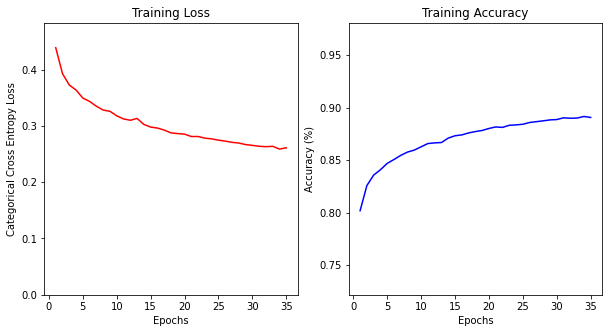

In [11]:
fig, ax = hcd.evaluation.plot_loss_and_accuracy(losses, accuracies)
fig.show()

### Evaluate Model on Validation Partition

In [ ]:
score, accuracy, loss = trainer.evaluate(val_loader, criterion)
print(f'Evaluating {model.__class__.__name__} on validation set:')
print('-'*30)
print('F1-Score:', score)
print('Accuracy:', accuracy)
print('Loss:', loss)

### Save Trained Model

In [ ]:
trainer.save_final_model()